In [1]:
import numpy as np
from generate_signal import generate_steering_vector, generate_R_hat
from draw_plot import plot_single_music
from scipy.signal import find_peaks

def music_method(X, nbSensors, nbSources, print_angles = False, draw_plot = False):
    angles_range = np.linspace(-90, 90, 1801) # Angles que l'on souhaite tester
    R_hat = generate_R_hat(X)

    # Calculer les vecteurs propres et les valeurs propres
    _, eigenvectors = np.linalg.eigh(R_hat)
    # Sélectionner les k plus grandes valeurs propres
    noise_subspace = eigenvectors[:, :nbSources]

    # Calcul du spectre MUSIC
    music_spectrum = np.zeros_like(angles_range, dtype=float)
    for idx, theta in enumerate(angles_range):
        steering_vector = generate_steering_vector(nbSensors, theta)
        music_spectrum[idx] = 1 / np.linalg.norm(noise_subspace.conj().T @ steering_vector)
    
    
    # Estimation des angles
    estimated_angles = estimate_angles(nbSources, music_spectrum, angles_range)

    if print_angles: # print les angles estimés si True
        print(estimated_angles)
    if draw_plot: # Trace un graphique du spectre de beamforming si True
        plot_single_music(music_spectrum, angles_range)

    return estimated_angles

def estimate_angles(nbSources, music_spectrum, angles_range):
    all_peaks, _ = find_peaks(np.real(music_spectrum), height=0)  # height=0 pour inclure tous les pics
    sorted_peaks = sorted(all_peaks, key=lambda x: music_spectrum[x], reverse=True) # Triez les pics par amplitude dans l'ordre décroissant
    top_peaks = sorted(sorted_peaks[:nbSources]) # Sélectionnez les deux plus grands pics
    estimated_angles = angles_range[top_peaks] # Obtenez les angles estimés correspondant aux deux pics
    return estimated_angles

In [3]:
import numpy as np

def generate_noise(sd, size):
    # Générer un bruit aléatoire complexe avec une distribution gaussienne
    real_part = np.random.normal(0, sd, size)
    imag_part = np.random.normal(0, sd, size)
    # Créer un tableau complexe à partir des parties réelle et imaginaire
    noise_vector = np.vectorize(complex)(real_part, imag_part)
    return noise_vector

def generate_steering_vector(nbSensors, theta, d = 1, wavelength = 2):
    # Génération du steering vector
    steering_vector = np.exp(-1j * np.arange(nbSensors) * 2 * np.pi * d / wavelength * np.sin(np.radians(theta)))
    return steering_vector

def generate_S_matrix(nbSources, nbTimePoints, varList, correlation_List):
    # Vérification que le nombre de variances fournies est bon
    if len(varList) != nbSources:
        raise ValueError("Provide the correct number of variances. You need to have one variance for each source.")
    # Vérification que le nombre de corrélations fournies est bon
    if len(correlation_List) != nbSources * (nbSources - 1) // 2:
        raise ValueError("Provide the correct number of correlation coefficients. You need to have one correlation for each distinct pair of sources.")

    # Création d'une matrice carrée vide
    covariance_matrix = np.zeros((nbSources, nbSources))
    # Remplissage de la moitié haut-droite de la matrice de covariance
    k = 0
    for i in range(nbSources):
        for j in range(i + 1, nbSources):
            covariance_matrix[i, j] = _get_covariance(correlation_List[k], varList[i], varList[j])
            k+=1
    # Remplissage par symétrie de la moitié bas-droite
    covariance_matrix += covariance_matrix.T
    # Remplissage de la diagonale de la marice de covariance
    covariance_matrix += np.diag(varList)
    print(covariance_matrix)
    # Utiliser la décomposition de Cholesky pour obtenir une matrice L telle que L * transpose(L) = covariance_matrix
    L_cholesky = np.linalg.cholesky(covariance_matrix)
    # Générer la matrice S en utilisant la matrice L_cholesky
    S = np.dot(np.random.normal(0, 1, (nbTimePoints, nbSources)) + 1j * np.random.normal(0, 1, (nbTimePoints, nbSources)), L_cholesky.T)  # Chaque ligne est un signal source
    return S

def _get_covariance(correlation_coefficient, varA, varB):
    # Calcule une covariance à partir d'une corrélation
    covariance = correlation_coefficient * np.sqrt(varA * varB) # Calcul de la covariance
    return covariance

def generate_A_matrix(nbSensors, thetaList): # Génération de la Steering matrix
    A = []
    for theta in thetaList:
        A_t = generate_steering_vector(nbSensors, theta)
        A.append(A_t)
    A = np.transpose(np.array(A))
    return A

def generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, varList, correlation_List, signal_noise_ratio): # Génération de la matrice des signaux reçus
    # Vérification que le nombre d'angles theta fournis est bon
    if len(thetaList) != nbSources:
        raise ValueError("Provide the correct number of thetas. You need to have one theta for each source.")
    # Création dela matrice S
    S = generate_S_matrix(nbSources, nbTimePoints, varList, correlation_List)
    # Création dela matrice A
    A = generate_A_matrix(nbSensors, thetaList)
    # Initialisation de X
    X = []

    # Implémentation du rapport signal sur bruit (Signal Noise Ratio, SNR)
    if signal_noise_ratio is not False:
        signal_power = np.mean(np.abs(S)**2) # Calcul de la puissance du signal à partir de la matrice S
        noise_power = signal_power / 10**(signal_noise_ratio / 10) # Calculez la puissance du bruit en fonction du SNR
        #Création de la matrice X
        for i in range(nbTimePoints):
            b_t = generate_noise(np.sqrt(noise_power), nbSensors) # Bruit
            X_t = np.dot(A, S[i]) + b_t # Signal reçu à un instant t
            X.append(X_t)
        X = np.array(X)
    else:
        #Création de la matrice X
        for i in range(nbTimePoints):
            b_t = generate_noise(np.sqrt(2**-30), nbSensors) # Le Beamforming ne fonctionne pas si je ne rajoute pas un bruit minime pour une raison qui m'échappe
            X_t = np.dot(A, S[i]) + b_t# Signal reçu à un instant t
            X.append(X_t)
            if i < 1:
                print(np.dot(A, S[i]))
                print(X_t)
        X = np.array(X)
    return X

def generate_R_hat(X):
    # Calcul de la matrice de covariance R_hat du signal reçu
    R_hat = np.cov(X, rowvar=False)
    return R_hat

[[1.  0.4]
 [0.4 1. ]]
[-5.3  5.2]


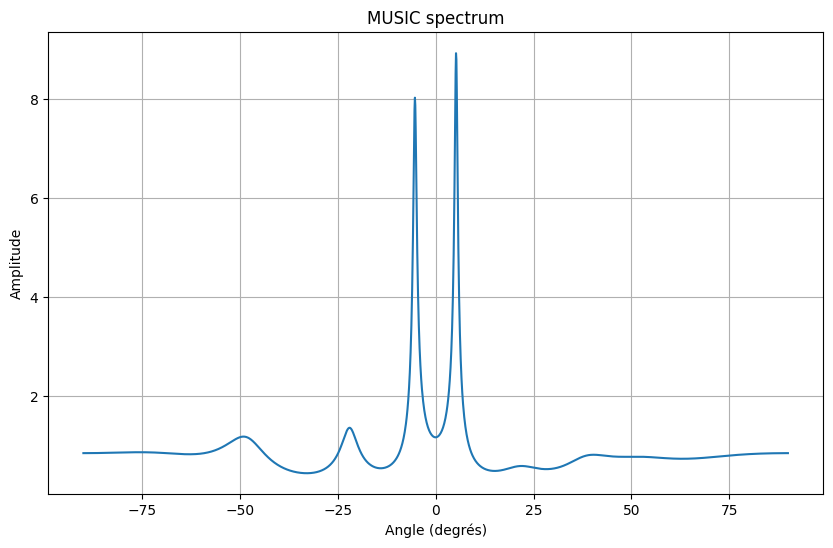

In [4]:

nbSources = 2 # Nombre de sources
nbSensors = 10 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 3 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = 5 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = -5 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var1 = 1 # Variance du signal 1
var2 = 1 # Variance du signal 2
correlation_List = [0.4] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche

thetaList = [theta1, theta2]
varList = [var1, var2]

X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, varList, correlation_List, signal_noise_ratio)
estimated_angles = music_method(X, nbSensors, nbSources, print_angles=True, draw_plot=True)

[[1.  0.4]
 [0.4 1. ]]
[-5.3  5.5]


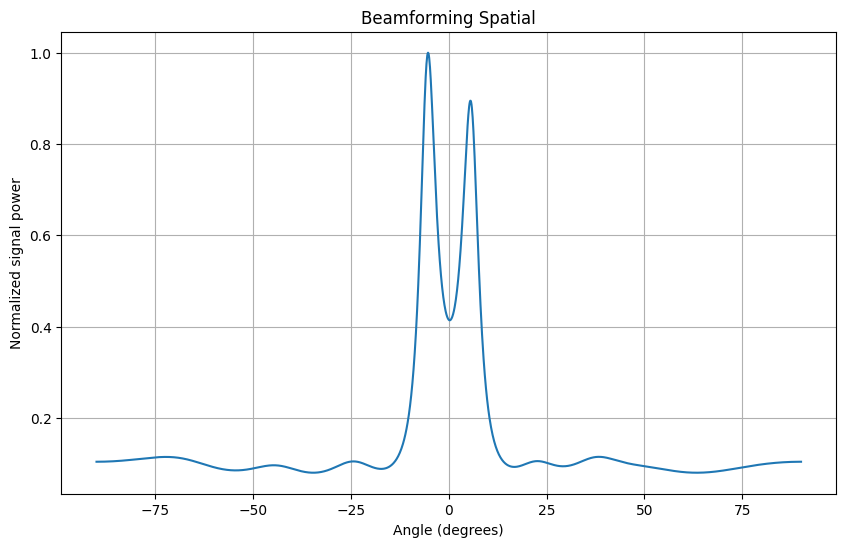

In [5]:
from generate_signal import generate_X_matrix
from beamforming import beamforming_method

nbSources = 2 # Nombre de sources
nbSensors = 10 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 3 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = 5 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = -5 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var1 = 1 # Variance du signal 1
var2 = 1 # Variance du signal 2
correlation_List = [0.4] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche.

thetaList = [theta1, theta2]
varList = [var1, var2]

X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, varList, correlation_List, signal_noise_ratio)
estimated_angles = beamforming_method(X, nbSensors, nbSources, print_angles=True, draw_plot=True)

In [9]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from generate_signal import generate_steering_vector, generate_R_hat

# Définition du modèle de réseau de neurones
class DOAEstimator(nn.Module):
    def __init__(self, input_size, output_size):
        super(DOAEstimator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pas de fonction d'activation ici car c'est une régression
        return x

# Classe Dataset pour les données DOA
class DOADataset(Dataset):
    def __init__(self, covariances, doas):
        assert len(covariances) == len(doas), "La taille des covariances doit correspondre à celle des doas"
        self.covariances = covariances
        self.doas = doas

    def __len__(self):
        return len(self.covariances)

    def __getitem__(self, idx):
        if idx < len(self.covariances):
            return self.covariances[idx], self.doas[idx]
        else:
            raise IndexError("Index en dehors des limites de l'ensemble de données")


# Paramètres de simulation (exemple)
nbSources = 2
nbSensors = 10
nbTimePoints = 100
thetaList = [30, -30]  # Exemple d'angles DoA
varList = [1, 1]
correlation_List = [0.5]
signal_noise_ratio = 10

# Génération des données
X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, varList, correlation_List, signal_noise_ratio)
R_hat = generate_R_hat(X)

R_hat = R_hat.reshape(len(R_hat), -1)


# Prétraitement des données
covariances_flattened = R_hat.reshape(len(R_hat), -1)
doas = np.array(thetaList)  # Remplacer par les valeurs réelles de DoA si disponibles

# Création du dataset et du dataloader
dataset = DOADataset(covariances_flattened, doas)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Création et entraînement du modèle
model = DOAEstimator(input_size=covariances_flattened.shape[1], output_size=len(doas))
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 10

# Boucle d'entraînement
for epoch in range(num_epochs):
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")


[[1.  0.5]
 [0.5 1. ]]


AssertionError: La taille des covariances doit correspondre à celle des doas